In [17]:
!pip install dask[dataframe]

/bin/pip:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import load_entry_point


In [18]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import joblib
from sklearn.utils import resample
from sklearn.manifold import TSNE

In [19]:
data = pd.read_csv("datasets_try/processed_features.csv")
data.head(5)

,vehicles_in_ego_lane,vehicles_in_left_lane,vehicles_in_right_lane,closest_in_ego_lane_dist,closest_left_lane_dist,closest_right_lane_dist,relative_velocity_ego_lane,relative_velocity_left_lane,relative_velocity_right_lane,action
0,1.0,3.0,4.0,61.76268,11.00473,21.79465,-1.691187,-3.999763,-1.228664,1.0
1,2.0,1.0,1.0,31.40597,52.71649,84.88040,-2.216423,-3.149021,-3.473845,4.0
2,4.0,0.0,4.0,10.71805,0.00000,21.06313,-3.656183,0.000000,-1.032003,4.0
3,2.0,1.0,0.0,10.47482,31.08163,0.00000,-1.970623,-3.944008,0.000000,4.0
4,3.0,0.0,1.0,11.60712,0.00000,96.90985,-1.953373,0.000000,-1.570948,4.0


Removing constant features

In [20]:
constant_columns = [col for col in data.columns if data[col].nunique() == 1]

# Remove constant columns from the dataframe
data_cleaned = data.drop(columns=constant_columns)

# Display the updated dataframe without constant columns
print("\nColumns removed (constant columns):", constant_columns)
print("\nDataFrame after removing constant columns:")
data_cleaned.head(10)


Columns removed (constant columns): []

DataFrame after removing constant columns:


,vehicles_in_ego_lane,vehicles_in_left_lane,vehicles_in_right_lane,closest_in_ego_lane_dist,closest_left_lane_dist,closest_right_lane_dist,relative_velocity_ego_lane,relative_velocity_left_lane,relative_velocity_right_lane,action
0,1.0,3.0,4.0,61.76268,11.00473,21.79465,-1.691187,-3.999763,-1.228664,1.0
1,2.0,1.0,1.0,31.40597,52.71649,84.88040,-2.216423,-3.149021,-3.473845,4.0
2,4.0,0.0,4.0,10.71805,0.00000,21.06313,-3.656183,0.000000,-1.032003,4.0
3,2.0,1.0,0.0,10.47482,31.08163,0.00000,-1.970623,-3.944008,0.000000,4.0
4,3.0,0.0,1.0,11.60712,0.00000,96.90985,-1.953373,0.000000,-1.570948,4.0
5,0.0,4.0,0.0,10000.00000,9.99283,0.00000,10000.000000,-3.377950,0.000000,1.0
6,2.0,0.0,4.0,9.84169,0.00000,19.75901,-3.411634,0.000000,-3.956556,4.0
7,0.0,3.0,0.0,10000.00000,45.08148,0.00000,10000.000000,-3.247915,0.000000,1.0
8,3.0,2.0,3.0,42.71913,21.33089,32.78527,-1.271141,-2.055294,-1.619541,4.0
9,4.0,2.0,2.0,10.91754,30.53202,20.91661,-1.149372,-1.960442,-3.083757,4.0


In [21]:
y = data_cleaned['action']

# Extract the features by dropping the target column ('action')
X = data_cleaned.drop('action', axis=1)  # axis=1 to drop a column

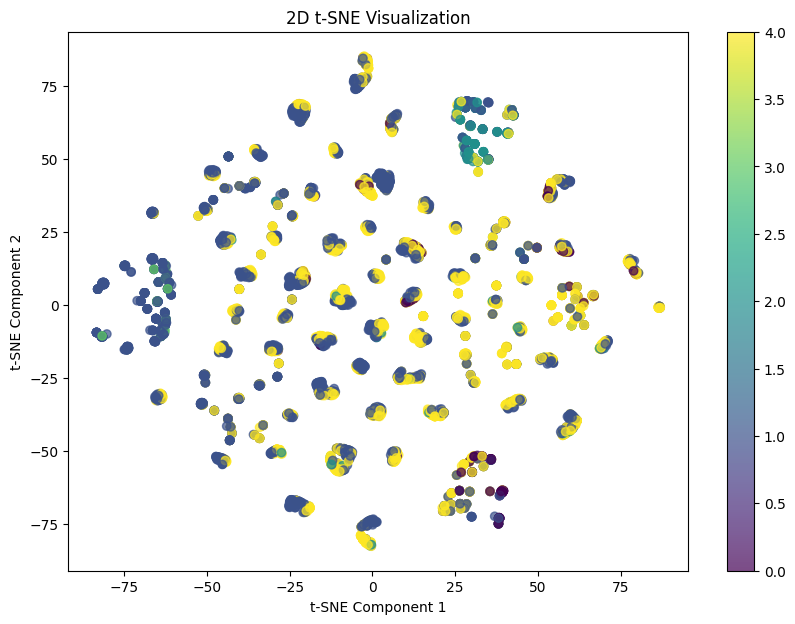

In [22]:
# Standardize the features 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply t-SNE to reduce to 2D
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Plotting the t-SNE results
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(scatter)
plt.title("2D t-SNE Visualization")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

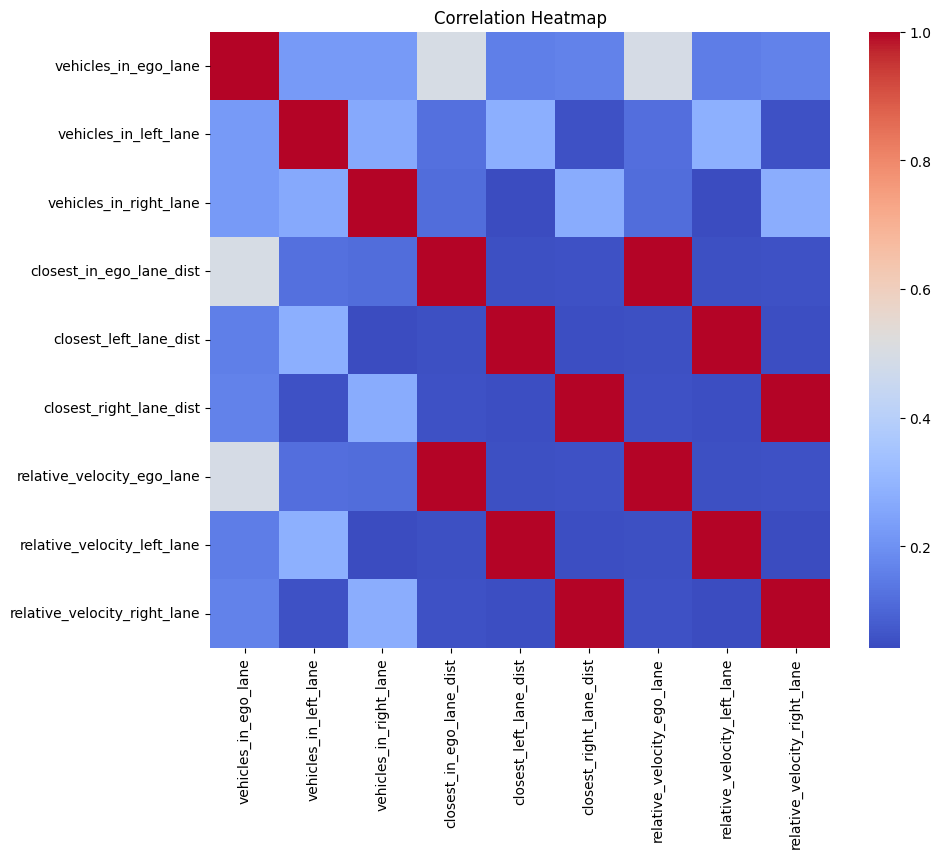

In [23]:
# Computing the correlation matrix
corr_matrix = X.corr()
# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(abs(corr_matrix), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [24]:
def label_hist(y):
  plt.figure(figsize=(10, 6))
  plt.hist(y, bins=5, color='blue', alpha=0.7, edgecolor='black')
  plt.title('Histogram of Labels')
  plt.xlabel('Labels')
  plt.ylabel('Frequency')
  plt.xticks(np.unique(y))  # Ensure all unique labels are shown on the x-axis
  plt.grid(axis='y', alpha=0.75)
  plt.show()

case 1 downsampling majority class

In [25]:
classes_to_downsample = [1, 4]
n_samples = 1000  # Replace with the desired number of samples

# Separate the classes to downsample
df_class_1 = data[data['action'] == 1]
df_class_4 = data[data['action'] == 4]

# Downsample class 1
df_class_1_downsampled = resample(df_class_1,
                                  replace=False,
                                  n_samples=n_samples,
                                  random_state=42)

# Downsample class 4
df_class_4_downsampled = resample(df_class_4,
                                  replace=False,
                                  n_samples=n_samples,
                                  random_state=42)

# Remove original classes 1 and 4 from the dataset
df_remaining = data[~data['action'].isin(classes_to_downsample)]

# Concatenate the downsampled classes with the remaining dataset
df_final = pd.concat([df_remaining, df_class_1_downsampled, df_class_4_downsampled])

# Shuffle the final dataset
df_final = df_final.sample(frac=1, random_state=42).reset_index(drop=True)

case 2 downsaampling majority and upsampling minority using SMOTE

In [26]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Apply SMOTEN to handle class imbalance
# smote = SMOTENC(['2_0.0', '2_4.0',
#        '2_8.0', '2_12.0', '7_0.0', '7_4.0', '7_8.0', '7_12.0', '12_0.0',
#        '12_4.0', '12_8.0', '12_12.0', '17_0.0', '17_4.0', '17_8.0', '17_12.0',
#        '22_0.0', '22_4.0', '22_8.0', '22_12.0', '27_0.0', '27_4.0', '27_8.0',
#        '27_12.0', '32_0.0', '32_4.0', '32_8.0', '32_12.0', '37_0.0', '37_4.0',
#        '37_8.0', '37_12.0', '42_0.0', '42_4.0', '42_8.0', '42_12.0', '47_0.0',
#        '47_4.0', '47_8.0', '47_12.0'], sampling_strategy="auto",
#               k_neighbors=2,
#               random_state=42)
smote = SMOTE(sampling_strategy="auto",
               k_neighbors=2,
               random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

categorical class,  replaced by 1 hot encoding

In [27]:
# Identify columns that have exactly 4 unique values
columns_with_4_unique = [col for col in data_cleaned.columns if data_cleaned[col].nunique() == 4 and col!='action']

# Display columns with 4 unique values
print("\nColumns with exactly 4 unique values:")
print(columns_with_4_unique)

# One-hot encode the columns with 4 unique values
df_encoded = pd.get_dummies(data_cleaned, columns=columns_with_4_unique,dtype=int)

# Display the encoded dataframe
print("\nDataFrame after one-hot encoding:")
df_encoded.head()


Columns with exactly 4 unique values:
[]

DataFrame after one-hot encoding:


,vehicles_in_ego_lane,vehicles_in_left_lane,vehicles_in_right_lane,closest_in_ego_lane_dist,closest_left_lane_dist,closest_right_lane_dist,relative_velocity_ego_lane,relative_velocity_left_lane,relative_velocity_right_lane,action
0,1.0,3.0,4.0,61.76268,11.00473,21.79465,-1.691187,-3.999763,-1.228664,1.0
1,2.0,1.0,1.0,31.40597,52.71649,84.88040,-2.216423,-3.149021,-3.473845,4.0
2,4.0,0.0,4.0,10.71805,0.00000,21.06313,-3.656183,0.000000,-1.032003,4.0
3,2.0,1.0,0.0,10.47482,31.08163,0.00000,-1.970623,-3.944008,0.000000,4.0
4,3.0,0.0,1.0,11.60712,0.00000,96.90985,-1.953373,0.000000,-1.570948,4.0


In [28]:
df_encoded.columns

Index(['vehicles_in_ego_lane', 'vehicles_in_left_lane',
       'vehicles_in_right_lane', 'closest_in_ego_lane_dist',
       'closest_left_lane_dist', 'closest_right_lane_dist',
       'relative_velocity_ego_lane', 'relative_velocity_left_lane',
       'relative_velocity_right_lane', 'action'],
      dtype='object')

class weights if neccessary

In [29]:
X = df_encoded.drop(columns=['action'])
y = df_encoded['action']
class_mapping = {0: 0, 1: 1, 2: 2,4:3}
y = y.map(class_mapping)

In [30]:
# Standardize the features
scaler = StandardScaler()
X_res_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=0.98)  # Retain 99% of variance
X_res_pca = pca.fit_transform(X_res_scaled)
X_test_pca = pca.transform(X_test_scaled)



rf

Random Forest Model Accuracy: 81.90%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.56      0.47      0.51        38
         1.0       0.87      0.85      0.86       489
         2.0       0.64      0.68      0.66        44
         3.0       0.25      0.20      0.22         5
         4.0       0.80      0.84      0.82       424

    accuracy                           0.82      1000
   macro avg       0.63      0.61      0.62      1000
weighted avg       0.82      0.82      0.82      1000

Confusion Matrix:
 [[ 18   4   0   0  16]
 [  3 415   8   3  60]
 [  0   3  30   0  11]
 [  0   4   0   1   0]
 [ 11  49   9   0 355]]


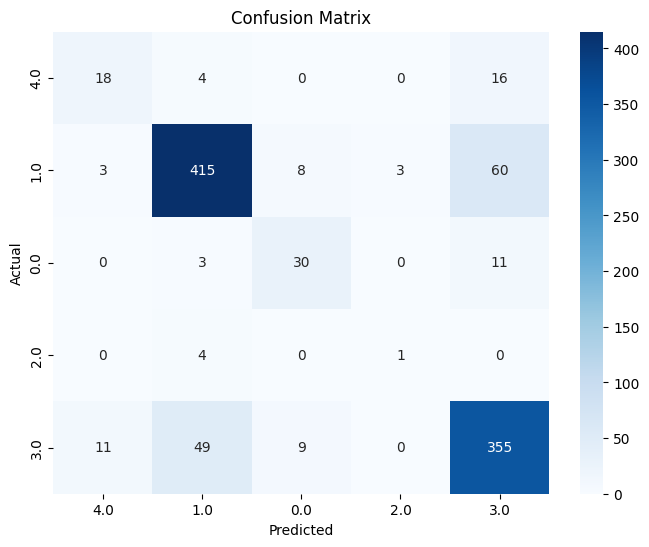

In [31]:
  # Initialize and train the Random Forest model
rf_model = RandomForestClassifier(
bootstrap=False,
max_depth=30,
max_features='sqrt',
min_samples_leaf=1,
min_samples_split=5,
n_estimators=500,
random_state=42, class_weight = "balanced"
)

    # # Define the hyperparameters and their values to be searched
    # param_grid = {
    #     'n_estimators': [100, 500, 1000],  # Number of trees in the forest
    #     'max_depth': [10, 20, 30, None],  # Maximum depth of each tree
    #     'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    #     'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required in a leaf node
    #     'max_features': ['auto', 'sqrt'],  # Number of features to consider when looking for the best split
    #     'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
    # }

    # # Apply GridSearchCV to search for the best hyperparameters
    # grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
    #                         cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

    # # Fit the grid search
    # grid_search.fit(X_train, y_train)

    # # View the best hyperparameters
    # print("Best Hyperparameters:", grid_search.best_params_)

    #Predict using the best model

rf_model.fit(X_train, y_train)

# Step 5: Model Evaluation on Test Data
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Model Accuracy: {accuracy * 100:.2f}%")

# Classification report
class_report = classification_report(y_test, y_pred, output_dict=True)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=y_test.unique(), yticklabels=y_test.unique())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

XGB

In [32]:
# Initialize and fit the XGBClassifier
xgb_model = XGBClassifier()
#xgb_model.fit(X_res_pca, y_train)
xgb_model.fit(X_train, y_train)
# Predict on test data
#y_pred = xgb_model.predict(X_test_pca)
y_pred = xgb_model.predict(X_train)

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"xgb Model Accuracy: {accuracy * 100:.2f}%")

# Classification report
class_report = classification_report(y_test, y_pred, output_dict=True,zero_division=1)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix (optional for further evaluation)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

ValueError: Found input variables with inconsistent numbers of samples: [1000, 9930]

CLASS 4 ALMOST CONFUSED WITH EVERY CLASS

In [ ]:
from sklearn.ensemble import VotingClassifier

lgbm = LGBMClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()

voting_clf = VotingClassifier(estimators=[
    ('xgb', xgb), ('rf', rf), ('lgbm', lgbm)],

    voting='soft')
voting_clf.fit(X_res_pca, y_train)
y_pred_ensemble = voting_clf.predict(X_test_pca)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 9930, number of used features: 20
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438


In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(xgb_model, X_res_pca, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {scores}")
print(f"Mean accuracy: {scores.mean():.2f}")

KeyboardInterrupt: 

In [ ]:
# Confusion matrix (optional for further evaluation)
conf_matrix = confusion_matrix(y_test, y_pred_ensemble)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[  9  10   1  22]
 [  5 405   3  95]
 [  0   8   3  25]
 [ 15 161   3 230]]


In [ ]:
# Accuracy score
accuracy = accuracy_score(y_test, y_pred_ensemble)
print(f"Ensemble Model Accuracy: {accuracy * 100:.2f}%")
class_report = classification_report(y_test, y_pred_ensemble, output_dict=True,zero_division=1)
print("Classification Report:")
print(classification_report(y_test, y_pred_ensemble))

Ensemble Model Accuracy: 65.03%
Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.21      0.25        42
           1       0.69      0.80      0.74       508
           2       0.30      0.08      0.13        36
           3       0.62      0.56      0.59       409

    accuracy                           0.65       995
   macro avg       0.48      0.41      0.43       995
weighted avg       0.63      0.65      0.64       995



MLP CLASSIFIER

In [ ]:
from sklearn.neural_network import MLPClassifier
# Create an MLP Classifier with class weights to handle imbalanced classes
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

# Fit the model
mlp.fit(X_train, y_train)

# Make predictions
y_pred = mlp.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.28      0.61      0.39        38
         1.0       0.75      0.85      0.79       489
         2.0       0.07      0.23      0.10        44
         3.0       0.04      0.20      0.06         5
         4.0       0.87      0.38      0.52       424

    accuracy                           0.61      1000
   macro avg       0.40      0.45      0.37      1000
weighted avg       0.75      0.61      0.63      1000



SVC ONE CLASS

In [ ]:
from sklearn.svm import SVC
# Create a Support Vector Classifier with class weights to handle imbalanced classes
svc = SVC(kernel='linear', class_weight='balanced', random_state=42)

# Fit the model
svc.fit(X_train, y_train)

# Make predictions
y_pred = svc.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))